In [299]:
import json
from tqdm import tqdm
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import re
import json
from openai import OpenAI
from tqdm import tqdm
import yfinance as yf
api_key = "openai key here"
client = OpenAI(api_key=api_key)

In [16]:
def get_next_day_price_movement(prices, dates):
    movements = {}
    for date in dates:
        close = prices.loc[date]['Close'].values
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        new_date_obj = date_obj + timedelta(days=1)
        next_day = new_date_obj.strftime("%Y-%m-%d")
        open = prices.loc[next_day]['Open'].values
        change = open/close - 1
        movements[date] = change.item()
    return movements

In [17]:
def get_gpt_response(message, model="gpt-4o"):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=message,
            max_tokens=5000,
        )
        answer = response.choices[0].message.content
        return answer

    except Exception as e:
        print(f"Error: {e}")

In [197]:
prompt_1 = """Your task is to carefully read an earnings call transcript and extract the most important facts that may influence the stock price for the next trading day. You should find out as many independent facts as possible. Additionally, note the sentiment of the company speakers (e.g., optimism, caution, concern) and include it as one of the facts.

### Instructions:
1. **Understand the Context**:
   - Identify the company's current financial performance, focusing on metrics like revenue, net income, earnings per share (EPS), and margins.
   - Look for any forward-looking statements, guidance updates, or outlooks provided by the management.
   - Pay attention to the tone and sentiment of the company speakers, capturing whether they express optimism, caution, or concern.

2. **Extract Key Facts**:
   - Highlight critical announcements such as product launches, partnerships, acquisitions, or divestitures.
   - Note any surprising or significant statements, such as exceeding or missing market expectations (e.g., EPS beats, revenue misses).
   - Pay attention to comments on macroeconomic trends or external factors affecting the company (e.g., interest rates, supply chain issues).

3. **Identify Market-Relevant Insights**:
   - Distill facts that the market is likely to react to, such as:
     - Surprises in earnings or guidance.
     - Innovations, new market entries, or expansion plans.
     - Management tone or sentiment shifts (e.g., optimism, caution).

### Response Format:

1. [State the fact clearly, including relevant numbers or details.]
2. [State another fact.]
3. [more facts]
......
n. [Include the sentiment of the company speakers, with specific examples where possible.]


Remember to only provide your response in the specified format, including facts and sentiment. Do not provide any additional commentary or analysis.

Here is the earnings call transcript for your analysis:"""

In [198]:
prompt_2 = """
### Task: Analyze and Predict Next-Day Stock Price Movement

You are tasked with analyzing key facts extracted from an earnings call transcript to predict the company's stock price movement for the next trading day. Your goal is to evaluate each fact and predict its potential impact using **if-then-because** statements. These statements should reflect how the fact may influence the stock price and provide clear reasoning based on near-term market behavior and sentiment.

---

### **Response Format**:
If [summarize the fact], then [how it would affect the next day stock price], because [the rationale behind it, considering near-term market behavior and sentiment].
If [summarize the fact], then [how it would affect the next day stock price], because [the rationale behind it, considering near-term market behavior and sentiment].
If [summarize the fact], then [how it would affect the next day stock price], because [the rationale behind it, considering near-term market behavior and sentiment].
...

---

### **Important Guidelines**:
1. **Focus on the Short-Term**: Your analysis should focus specifically on **next trading day** stock price movement.
2. **Consider Market Reactions**:
   - Account for surprises, forward guidance, sentiment, and sector-specific trends.
   - Reflect on investor expectations and how they align with the facts.
3. **Rely on Market Behavior and Sentiment**:
   - Use near-term behavior such as momentum effects or emotional reactions to surprises as part of your rationale.
4. **Abstraction of Facts**:
   - Where appropriate, generalize or abstract facts to make the analysis more effective and insightful.
5. **Strict Adherence to the Format**:
   - Only provide **if-then-because** statements.
   - Do not include additional commentary, analysis, or explanations outside the specified format.

---

### Input:
Here are the extracted facts for your analysis:  
"""

In [272]:
prompt_3 = """
### Task: Predict the Next Day Stock Price Movement

You are a financial analyst AI tasked with predicting the next day's stock price movement for a company based on information from its most recent earnings call. You will be provided with the following inputs:

1. **Facts**: Key information extracted from the company's earnings call transcript. These facts include:
   - Financial performance metrics (e.g., revenue growth, EPS, margins).
   - Product announcements, guidance updates, and other relevant data.

2. **If-Then-Because Statements**: Statements that describe how next-day stock price movements have historically been influenced by similar facts. These statements have been accumulated from prior earnings calls and are provided as a reference. Past statements may also be useful.

---

### **Your Task**:
1. **Identify Relevant Facts and Statements**:
   - Determine which facts and statements are most relevant for predicting the next day's stock price movement.
   - Focus on the key drivers of market reaction (e.g., surprises, forward guidance, or sentiment).

2. **Analyze the Relevant Information**:
   - Analyze how the selected facts align with the relevant if-then-because statements.
   - Provide a concise explanation of how the facts and statements together influence your prediction.

3. **Predict the Next Day’s Stock Price Movement**:
   - Choose one of the following categories for your prediction:
     - **Positive Surprise** (+3% or more): A strong positive market reaction.
     - **Moderate Positive** (+1% to +3%): A modest positive market reaction.
     - **Flat Response** (-1% to +1%): Little to no significant market reaction.
     - **Moderate Negative** (-1% to -3%): A modest negative market reaction.
     - **Negative Surprise** (-3% or more): A strong negative market reaction.

---

### **Response Format**:
Analysis: Provide an analysis explaining how the facts and selected statements drive your prediction. Focus on the key factors and rationale.

Statements Used: List the numbers of the statements you used in your analysis.

Prediction: Choose one of the five categories.

---

### **Input Example**:

**Facts**:
- Alphabet Inc. reported Q3 2024 revenue growth of 15% year-over-year to $76.5 billion for Google Services and 35% growth in Google Cloud revenues, reaching $11.4 billion, with a 17% operating margin.
- Alphabet's consolidated net income increased 34% to $26.3 billion, with earnings per share rising 37% to $2.12, alongside operating margin expansion to 32%.
- Alphabet plans to invest heavily in AI infrastructure, maintaining Q4 CapEx at Q3's $13 billion level, primarily for servers and data centers, with further increases expected in 2025.

**Statements**:
1. If Alphabet reported Q3 2024 revenue growth of 15% for Google Services and 35% for Google Cloud with strong operating margins, then the stock price is likely to increase, because these metrics suggest robust financial performance, exceeding market expectations, and highlight Alphabet's growing dominance in high-margin cloud services.
2. If Alphabet's consolidated net income grew 34% to $26.3 billion and EPS rose 37%, with operating margins expanding to 32%, then the stock price is likely to increase, because these financial metrics exceed expectations and demonstrate effective cost management, boosting investor sentiment.
3. If Alphabet plans to invest heavily in AI infrastructure, maintaining $13 billion in CapEx for Q4 and increasing in 2025, then the stock price could face slight pressure, because while such investments signal long-term growth, short-term investors may worry about increased expenses impacting near-term profitability.

---

### **Output Example**:
Analysis: Alphabet's Q3 earnings reflect robust financial performance, with strong revenue growth in Google Services and Cloud and significant EPS increases. These factors suggest positive market sentiment. However, heavy AI infrastructure investments and management's warnings of tougher year-over-year comparisons may temper investor enthusiasm. While the long-term growth prospects are strong, the market may focus on near-term profitability concerns, leading to mixed reactions.

Statements Used: 1, 2

Prediction: Flat Response (-1% to +1%)

---

### **Instructions**:
1. Focus on identifying and analyzing the most relevant facts and statements.
2. Base your analysis and prediction on short-term market reactions (next trading day).
3. Use the provided response format strictly, without adding unnecessary commentary or deviating from the task.

Here are the facts and statements for your analysis:  
"""

In [273]:
prompt_4 = """### **Prompt for Evaluating Statements**

You are an AI tasked with analyzing the usefulness and correctness of **if-then-because** statements for predicting the next day’s stock price movement. Your primary goal is to evaluate how well these statements contribute to the next day price prediction task and to recommend refinements or eliminations for statements that are not useful or accurate for this specific purpose.

---

### **Inputs**:
1. **Prediction Results**:  
   - The correctness of the previous stock price prediction based on five categories:  

2. **Facts Used**:  
   - The facts from the earnings call transcript that were used in the prediction.  

3. **Statements Used**:  
   - The **if-then-because** statements that were referenced in the prediction.  

4. **Actual Stock Movement**:  
   - The observed stock price movement category after the earnings call.  

---

### **Your Task**:
1. **Overall Analysis**:  
   - Assess the correctness of the expert’s prediction compared to the actual stock movement.  
   - Analyze the factors that contributed to the prediction's correctness or incorrectness, such as whether the facts and statements used were relevant and aligned with market behavior. If the input text didn't give sufficient information, use your own financial expertise. 

2. **Evaluate Each Statement**:  
   For each **if-then-because** statement, perform the following:  
   - Rate its **Relevance for Next-Day Prediction**: High/Medium/Low.  
   - Rate its **Rationale Consistency**: Consistent/Inconsistent.  
   - Provide a brief explanation of how this statement impacted the prediction’s correctness or incorrectness.  

3. **Suggest Improvements or Eliminations**:  
   - Refine statements that require improvement in their expected outcomes or rationale.  
   - Eliminate statements that are irrelevant or inaccurate for next-day predictions.  

---

### **Response Format**:  

**Overall Analysis**:  
- [Summary of how correct/incorrect the prediction was and key factors influencing its accuracy.]

**Analysis of Statements**:  
1. [Restate the statement]  
   - Relevance for Next-Day Prediction: [High/Medium/Low]  
   - Rationale Consistency: [Consistent/Inconsistent]  
   - Notes: [Brief explanation of why the statement is or isn’t effective for next-day price predictions.]  

2. [Restate the statement]  
   - Relevance for Next-Day Prediction: [High/Medium/Low]  
   - Rationale Consistency: [Consistent/Inconsistent]  
   - Notes: [Brief explanation.]

...

**Suggestions**:  
- **Statements to Refine**:  
  - [ID and refined version of statements that need improvement.]  
- **Statements to Eliminate**:  
  - [ID of the statements that are no longer useful.]

---

### **Example Input**:  

**Prediction Results**: Moderate Positive (+1% to +3%)  
**Facts Used**:  
- **Fact 1**: Alphabet's revenue grew by 15% YoY, with Google Cloud growing by 35%.  
- **Fact 2**: Operating margins increased to 32%.  
- **Fact 3**: Alphabet announced a significant increase in AI-related capital expenditures.  

**Statements Used**:  
1. If a company's revenue grows significantly and beats expectations, then the stock price is likely to rise because strong revenue performance signals robust business health and growth potential.  
2. If operating margins improve, then the stock price is likely to rise because higher margins indicate improved profitability and operational efficiency.  
3. If a company announces a significant increase in capital expenditures, then the stock price is likely to fall because high CapEx raises concerns about near-term profitability.  

**Actual Stock Movement**: Flat Response (-1% to +1%)

---

### **Example Output**:  

**Overall Analysis**:  
The expert's prediction of "Moderate Positive" was slightly incorrect, as the actual stock movement was a "Flat Response." While revenue and operating margin improvements supported a positive outlook, the market appeared more cautious due to increased capital expenditures. The CapEx statement assumed a negative reaction but overlooked the strategic nature of these investments, which balanced market sentiment.

---

**Analysis of Statements**:  
1. If a company's revenue grows significantly and beats expectations, then the stock price is likely to rise because strong revenue performance signals robust business health and growth potential.  
   - Relevance for Next-Day Prediction: High  
   - Rationale Consistency: Consistent  
   - Notes: This statement aligned with the facts but overestimated the positive impact, as the market likely priced in the revenue growth beforehand.  

2. If operating margins improve, then the stock price is likely to rise because higher margins indicate improved profitability and operational efficiency.  
   - Relevance for Next-Day Prediction: High  
   - Rationale Consistency: Consistent  
   - Notes: This statement correctly identified profitability improvements but did not fully account for other balancing factors like CapEx.  

3. If a company announces a significant increase in capital expenditures, then the stock price is likely to fall because high CapEx raises concerns about near-term profitability.  
   - Relevance for Next-Day Prediction: Low  
   - Rationale Consistency: Inconsistent  
   - Notes: The market viewed CapEx investments as strategic, contributing to balanced sentiment rather than a decline.

---

**Suggestions**:  
- **Statements to Refine**:  
  - Original: 1. If a company's revenue grows significantly and beats expectations, then the stock price is likely to rise because strong revenue performance signals robust business health and growth potential.  
    Refined: 1. If a company's revenue grows significantly but aligns with expectations, then the stock price is likely to remain flat because the positive performance may already be priced in.  

- **Statements to Eliminate**:  
  - 3. If a company announces a significant increase in capital expenditures, then the stock price is likely to fall because high CapEx raises concerns about near-term profitability.  
  
**Notes**: 
- Remember to give your responses strictly in the format. Especially, remember to always give the number of a statement when making suggestions about refinement or elimination for better tracking. 
- As a financial analyst, you should be picky about the statements used since not all statements used were useful, that is, even if the prediction was only slightly incorrect or correct, you can still refine or eliminated statements as many as you want.

Here are the input:  
"""

In [274]:
def agent_1_get_facts(transcript, prompt):
    """
    given a single piece of transcript, return the facts associated with the transcript.
    :param transcript: {"time": time, "title": title, "content": content}, i.e. a single piece of transcript
    :param prompt: used to extract facts
    :return: {"title": title, "facts": a string of listed facts}
    """
    facts = {}
    title = transcript['title']
    content = transcript['content']
    message = [{"role": "system", "content": "You are an expert financial analyst with specialized knowledge in earnings call analysis and stock market prediction."},{"role": "user", "content": prompt + content}]
    response = get_gpt_response(message, "gpt-4o")
    facts['title'] = title
    facts['facts'] = response
    return facts

In [275]:
def agent_2_get_statements(fact, prompt):
    """
    given facts on a single piece of transcript, return statements based on facts
    :param fact: {"title": title, "facts": facts}
    :param prompt: used to generate statements based on facts
    :return: {0:{"title": title, "statement": statement}, 1:{"title": title, "statement": statement}, ...}
    """
    statements = {}
    id = 0
    title = fact['title']
    fact_list = fact['facts']
    message = [{"role": "system", "content": "You are an expert financial analyst with specialized knowledge in earnings call analysis and stock market prediction."},{"role": "user", "content": prompt + fact_list}]
    response = get_gpt_response(message, "gpt-4o") # response should be a string "- xxxx \n\n - xxxx \n\n - xxxx"
    statements_list = response.split('\n\n')
    for statement in statements_list:
        statements[id] = {"title": title, "statement": statement}
        id += 1
    return statements

In [276]:
def store_statements_in_storage(statements, storage): # 
    """
    given a new generated statement, merge it into the storage dictionary.
    :param statements: {0:{"title": title, "statement": statement}, 1:{"title": title, "statement": statement}, ...} statements from a single piece of transcript
    :param storage: statements from all past transcripts
    :return: updated storage
    """
    if len(storage) == 0:
        return statements
    last_id = list(storage.keys())[-1] + 1
    for content in statements.values():
        storage[last_id] = content
        last_id += 1
    return storage

In [277]:
def agent_3_get_predictions(facts, storage, prompt):
    """
    :param facts: {"title": title, "facts": a string of listed facts}
    :param storage:{0:{"title": title, "statement": statement}, 1:{xxxx}, 2:{xxxx}, ...}, statements from all past transcripts
    :param prompt: used for prediction
    :return: {"title": title, "used_statements": some statements from the storage, "prediction": prediction, "analysis": analysis}
    """
    title = facts['title']
    fact = facts['facts']
    statements = '\n\n'.join([str(id) + '. ' + content['statement'] for id, content in storage.items()])
    message = [{"role": "system", "content": "You are an expert financial analyst with specialized knowledge in earnings call analysis and stock market prediction."},{"role": "user", "content": prompt + '\n Facts:\n' + fact + '\nStatements:\n' + statements}]
    response = get_gpt_response(message, "gpt-4o")
    # response should have format: \nAnalysis: xxxxxx \nStatements Used: 1, 2, 3, 4\nPrediction: Flat Response
    response = parse_prediction_response(response)
    used_statement_id = response['statements_used']
    used_statements = {id: storage[id] for id in used_statement_id}
    prediction = {"title": title, "statements used": used_statements, 
                  "prediction": response['prediction'], "analysis": response['analysis']}
    return prediction

In [292]:
def parse_prediction_response(gpt_response):
    """
    Parse the GPT response to extract analysis, statements used, and prediction.

    Parameters:
        gpt_response (str): The full response text from GPT.

    Returns:
        dict: Parsed data including analysis, statements used, and prediction.
    """
    parsed_data = {}

    # Normalize response to handle extra newlines or inconsistent formatting
    response = re.sub(r"\s*\n\s*", " ", gpt_response).strip()  # Replace extra newlines with spaces

    # Handle Analysis section
    analysis_match = re.search(r"(?:Analysis[:\s]*)\s*(.+?)\s*(?:Statements Used|Statements used|Statements)", response, re.DOTALL)
    if analysis_match:
        parsed_data["analysis"] = analysis_match.group(1).strip()
    else:
        print("WARNING: wrong format encountered when parsing prediction response. Section: Analysis")
        parsed_data["analysis"] = None

    # Handle Statements Used section
    statements_match = re.search(r"(?:Statements Used|Statements used|Statements)[:\s]*([\d,\s]+)", response, re.DOTALL)
    if statements_match:
        try:
            statements_str = statements_match.group(1).strip()
            # Split on commas and convert to integers
            statements_list = [int(s.strip()) for s in statements_str.split(',') if s.strip()]
            parsed_data["statements_used"] = statements_list
        except ValueError:
            print("WARNING: wrong format encountered when parsing prediction response. Section: Statements Used")
            parsed_data["statements_used"] = None
    else:
        print("WARNING: wrong format encountered when parsing prediction response. Section: Statements Used")
        print(f"Prediction response\n {gpt_response}")
        parsed_data["statements_used"] = None

    # Handle Prediction section - stop at the first closing parenthesis
    prediction_match = re.search(r"(?:Prediction[:\s]*)\s*(.+?\))", response, re.DOTALL)
    if prediction_match:
        parsed_data["prediction"] = prediction_match.group(1).strip()
    else:
        print("WARNING: wrong format encountered when parsing prediction response. Section: Prediction")
        parsed_data["prediction"] = None

    return parsed_data


In [293]:
def agent_4_get_feedback(facts, prediction, actual, prompt):
    """
    :param facts: {"title": title, "facts": a string of listed facts}
    :param storage: {0:{"title": title, "statement": statement}, 1:{xxxx}, 2:{xxxx}, ...}, statements from all past transcripts
    :param prediction: {"title": title, "used_statements": some statements from the storage, "prediction": prediction, "analysis": analysis}, where used_statements = {id1:statement, id2:statement,...}
    :param actual: actual movement of the stock price in the next day
    :param prompt: used for refine statements
    :return: two dictionaries of refined statements and eliminated statements, each {id: statement,}
    """
    statements_used = '\n'.join([str(id) + s['statement'] for id, s in prediction['statements used'].items()])
    pred = prediction['prediction']
    facts = facts['facts']
    message = [{"role": "system", "content": "You are an expert financial analyst."},{"role": "user", "content": prompt + '\n**Prediction Results**' + pred + '\n**Facts Used**:\n' + facts + "\n**Statements Used**:\n" + statements_used + "\n**Actual Stock Movement**: " + actual}]
    response = get_gpt_response(message, "gpt-4o")
    refined, eliminated = parse_refine_response(response)
    return refined, eliminated

In [294]:
def parse_refine_response(response):
    """
    Parse the GPT response to extract refined and eliminated statements.

    Parameters:
        response (str): The full response text from GPT.

    Returns:
        dict: Refined statements in the form {id: refined_statement}.
        dict: Eliminated statements in the form {id: eliminated_statement}.
    """
    refined_statements_dict = {}
    eliminated_statements_dict = {}
    
    # Match refined statements using the context of "Original" and "Refined"
    refined_section_matches = re.findall(
        r"Original:\s(\d+)\.\s(.*?)\s+Refined:\s(.*?)(?=\n\n|- Statements|$)", 
        response, re.DOTALL
    )
    
    if not refined_section_matches:
        print("WARNING: No refined statements found in the response.")
        print(f"Feedback response: {response}")
    else:
        for statement_id, _, refined_statement in refined_section_matches:
            refined_statements_dict[int(statement_id)] = refined_statement.strip()
    
    # Match eliminated statements
    eliminated_statements_section = re.search(r"- Statements to Eliminate:\s*(.*?)(?=\n\n|\Z)", response, re.DOTALL)
    if not eliminated_statements_section:
        print("WARNING: No 'Statements to Eliminate' section found in the response.")
    else:
        eliminated_text = eliminated_statements_section.group(1).strip()
        eliminated_statements_matches = re.findall(r"(\d+)\.\s(.*?)(?=\n|$)", eliminated_text)
        
        if not eliminated_statements_matches:
            print("WARNING: No eliminated statements found in the response.")
        else:
            eliminated_statements_dict = {int(statement_id): statement.strip() for statement_id, statement in eliminated_statements_matches}

    return refined_statements_dict, eliminated_statements_dict

In [295]:
def price_movement_categories(movements):
    labels = {}
    for date in movements.keys():
        change = movements[date]
        if -0.01<=change <=0.01:
            labels[date] = "Flat Response (-1% to +1%)"
        elif 0.01<change<=0.03:
            labels[date] = "Moderate Positive (+1% to +3%)"
        elif change>0.03:
            labels[date] = "Positive Surprise (+1% to +3%)"
        elif -0.03<=change<-0.01:
            labels[date] = "Moderate Negative (-1% to -3%)"
        elif change<-0.03:
            labels[date] = "Negative Surprise (-3% or more)"
    return labels

In [296]:
def run(dataset, prices, output_file="output/trans_only/intermediate_results.jsonl"):
    """
    Run the framework given a single stock transcript and prices, storing intermediate results in a JSONL file.
    :param dataset: a list of dictionaries, each dict {"time":time, "title":title, "content":content} is a single transcript. Note that transcripts in dataset should be ordered by time.
    :param prices: a DataFrame of stock prices.
    :param output_file: the file where intermediate results will be stored as JSONL.
    :return: None
    """
    dates = [t["time"] for t in dataset]
    movements = get_next_day_price_movement(prices, dates)
    labels = price_movement_categories(movements)  # e.g., {'2015-01-29': 'Moderate Positive (+1% to +3%)'}
    storage = {}

    # Open the JSONL file for writing
    with open(output_file, "w") as file:
        for transcript in tqdm(dataset):
            date = transcript["time"]
            title = transcript["title"]
            facts = agent_1_get_facts(transcript, prompt_1)  # {"title": title, "facts": a string of listed facts}
            statements = agent_2_get_statements(facts, prompt_2)  # {0: {"title": title, "statement": statement}, ...}
            storage = store_statements_in_storage(statements, storage)  # Append the new statements to the storage
            prediction = agent_3_get_predictions(facts, storage, prompt_3)  # {"title": ..., "used_statements": ..., "prediction": ..., "analysis": ...}
            actual = labels[date]
            refined, eliminated = agent_4_get_feedback(facts, prediction, actual, prompt_4)  # each {id: statement}

            # Update storage with refined and eliminated statements
            for id1, ref in refined.items():
                assert id1 in storage.keys(), f"Refined statement ID {id1} not found in storage"
                storage[id1] = ref
            for id2 in eliminated.keys():
                assert id2 in storage.keys(), f"Eliminated statement ID {id2} not found in storage"
                storage.pop(id2, None)

            # Gather stats for logging
            statements_length = len(statements)
            storage_length = len(storage)
            statements_used_length = len(prediction["statements used"])
            refined_number = list(refined.keys())
            eliminated_number = list(eliminated.keys())
            pred_movement = prediction["prediction"]

            # Log intermediate variables to JSONL
            log_data = {
                "title": title,
                "date": date,
                "facts": facts,
                "statements": statements,
                "prediction": prediction,
                "storage_snapshot": storage.copy(),
                "stats": {
                    "statements_generated": statements_length,
                    "statements_in_storage": storage_length,
                    "statements_used": statements_used_length,
                    "refined_statements": refined_number,
                    "eliminated_statements": eliminated_number,
                },
                "actual_movement": actual
            }
            file.write(json.dumps(log_data) + "\n")

            # Console output for progress
            print(f"At {date}, agents prediction: {pred_movement}, actual movement: {actual}")
            print(f"After transcript analysis, {statements_length} statements were generated.")
            print(f"During prediction, {statements_used_length} statements were used.")
            print(f"After feedback, statements {refined_number} were refined; statements {eliminated_number} were eliminated.")
            print(f"At the end of this period, the storage now has {storage_length} statements.")
            print("---" * 10)

In [297]:
with open("data/goog_calls.jsonl", 'r') as f:
    dataset = [json.loads(trans) for trans in f]
    dataset = dataset[::-1] # ascending order by time
symbol = 'goog'
prices = yf.download(symbol, start='2014-11-01', end='2024-11-01')
prices = prices[['Open', 'Close']]
prices.index = prices.index.strftime('%Y-%m-%d')
output_file = "output/trans_only/goog_intermediate_results.jsonl"

[*********************100%***********************]  1 of 1 completed


In [298]:
run(dataset, prices, output_file)

  3%|▎         | 1/39 [00:45<28:56, 45.70s/it]

Feedback response: **Overall Analysis**:  
The expert's prediction of "Moderate Positive" matched the actual stock movement, which was also "Moderate Positive." The primary driver for the prediction was the significant growth in Google's core revenue streams, particularly the 18% year-over-year increase in sites revenue and a strong performance in mobile search, which correctly anticipated the market's response. 

**Analysis of Statements**:  

1. If Google’s sites revenue increased by 18% year-over-year to $12.4 billion, with a 10% increase quarter-over-quarter, driven by strong mobile search performance, then the stock price is likely to rise the next trading day, because strong growth in core revenue streams indicates successful adaptation to market trends and investor confidence.  
   - Relevance for Next-Day Prediction: High  
   - Rationale Consistency: Consistent  
   - Notes: This statement effectively captured the essence of Google's core business strength in a high-growth are

  5%|▌         | 2/39 [01:31<28:21, 45.99s/it]

At 2015-04-23, agents prediction: Flat Response (-1% to +1%), actual movement: Positive Surprise (+1% to +3%)
After transcript analysis, 15 statements were generated.
During prediction, 6 statements were used.
After feedback, statements [1] were refined; statements [] were eliminated.
At the end of this period, the storage now has 31 statements.
------------------------------


  5%|▌         | 2/39 [01:44<32:15, 52.31s/it]


KeyboardInterrupt: 

In [261]:
def check_response(path):
    with open(path,"r") as f:
        data = [json.loads(line) for line in f]
    return data

In [286]:
str(1)

'1'

In [287]:
res = check_response(output_file)
res

[{'title': 'Google (GOOG) Q4 2014 Results - Earnings Call Transcript',
  'date': '2015-01-29',
  'facts': {'title': 'Google (GOOG) Q4 2014 Results - Earnings Call Transcript',
   'facts': "1. Google's Q4 2014 total consolidated revenue grew by 15% year-over-year to $18.1 billion, with 18% growth excluding currency fluctuations.\n2. The strengthening of the U.S. dollar caused a negative currency impact of $616 million on revenue; however, thanks to hedging, the net impact was $468 million.\n3. Due to inventory issues with Nexus 6, Google faced challenges meeting forecasted demand, impacting hardware revenue.\n4. Gross aggregate paid clicks increased by 14% year-over-year, while aggregate cost-per-clicks (CPCs) decreased by 3% year-over-year.\n5. Google Sites revenue was up 18% year-over-year, driven by strong mobile search and holiday performance.\n6. The company made significant real estate investments totaling over $900 million in Q4 to alleviate current workspace pressures and accomm

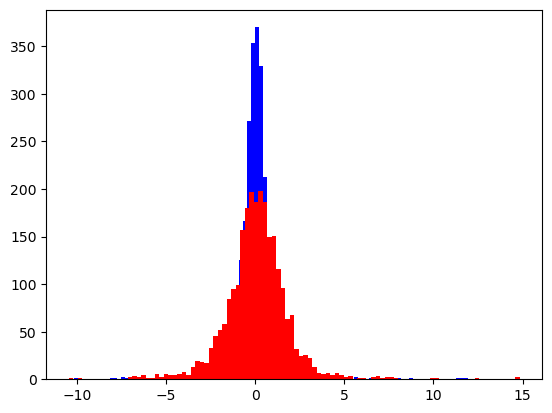

In [102]:
changes_overnight = prices[( 'Open', 'GOOG')][1:].values / prices[( 'Close', 'GOOG')][:-1].values - 1
changes_per_day = prices[( 'Open', 'GOOG')][1:].values / prices[( 'Open', 'GOOG')][:-1].values - 1
import matplotlib.pyplot as plt
plt.hist(changes_overnight * 100, bins=100, color='blue')
plt.hist(changes_per_day * 100, bins=100, color='red')
plt.show()